In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [10]:
def load_csvs_into_df(dir):
    dirs = [os.path.join(dir,d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    dfs = []
    for d in dirs:
        seeds = [f for f in os.listdir(os.path.join('./',d)) if f.startswith('seed')]
        for seed in seeds:
            results = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('test_results')][0]
            results_df = pd.read_csv(os.path.join(d, seed, results))
            dfs.append(results_df)
    df = pd.concat(dfs)
    return df

In [11]:
df = load_csvs_into_df('./')

In [12]:
df = df[["test/lungOpacity_young_subgroupAUROC","test/lungOpacity_old_subgroupAUROC","job_type_mod"]]
# extract number at the end of job_type_mod
df['job_type_mod'] = df.job_type_mod.str.extract('(\d+)')
# insert '.' after first character in job_type_mod
df['job_type_mod'] = df.job_type_mod.str[:1] + '.' + df.job_type_mod.str[1:]
# cast job_type_mod to float
df['job_type_mod'] = df['job_type_mod'].astype(float)

In [13]:
# melt columns to rows
df = pd.melt(df.reset_index(), id_vars=['job_type_mod'], value_vars=['test/lungOpacity_young_subgroupAUROC','test/lungOpacity_old_subgroupAUROC'])

In [14]:
df.variable = df.variable.str.replace('test/lungOpacity_young_subgroupAUROC','young')
df.variable = df.variable.str.replace('test/lungOpacity_old_subgroupAUROC','old')

In [15]:
df.head()

,job_type_mod,variable,value
0,0.700,young,0.6112
1,0.900,young,0.6112
2,0.300,young,0.6112
3,0.500,young,0.6116
4,0.001,young,0.6098


In [16]:
# load weight 1 data-sets
df_1 = load_csvs_into_df('../2023-07-13 09:20:21-FAE-rsna-age-bs1024-mgn001-DP')
df_1 = df_1[['test/lungOpacity_young_subgroupAUROC','test/lungOpacity_old_subgroupAUROC','protected_attr_percent']]
df_1['job_type_mod'] = 1
df_1 = pd.melt(df_1, id_vars=['protected_attr_percent','job_type_mod'], value_vars=['test/lungOpacity_young_subgroupAUROC','test/lungOpacity_old_subgroupAUROC'])
# only select rows where protected_attr_percent is 0.25, 0.5, 0.75
df_1 = df_1[df_1.protected_attr_percent.isin([0.75])]
df_1.drop(columns=['protected_attr_percent'], inplace=True)
df_1.variable = df_1.variable.str.replace('test/lungOpacity_young_subgroupAUROC','young')
df_1.variable = df_1.variable.str.replace('test/lungOpacity_old_subgroupAUROC','old')
df_1.head()

,job_type_mod,variable,value
2,1,young,0.6044
3,1,young,0.6006
12,1,old,0.8070
13,1,old,0.8020


In [17]:
# concat df and df_1
df = pd.concat([df,df_1])

22°, 51%, 59% -> cc8861
218°, 30%, 50% -> 5975A4

[Text(0, 0.5, 'subgroup AUROC')]

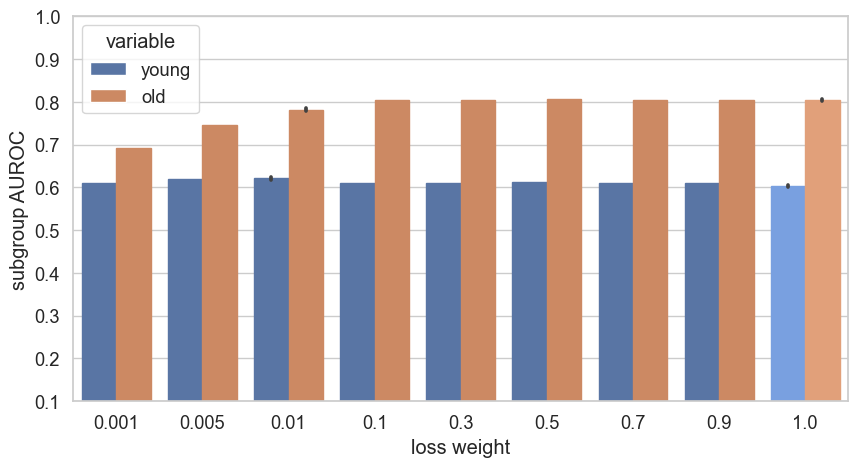

In [18]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.2, style="whitegrid")
g = sns.barplot(x='job_type_mod', y='value', hue='variable', data=df)
custom_colors = ["#5975A4"]*8 + ["#79a0e0"] + ["#CC8963"]*8 + ["#e1a07a"]
for i, bar in enumerate(g.patches):
    bar.set_color(custom_colors[i])
# set y axis limit
g.set(ylim=(0.1, 1))
g.set(xlabel='loss weight')
g.set(ylabel='subgroup AUROC')
# put legend outside of plot
# plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)